## 00. 환경설정

In [1]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

from surprise import KNNBasic, KNNWithMeans, SVD
from surprise.model_selection.validation import cross_validate

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

## 01. Matrix Factorization 구현
- SGD 최적화를 이용하여 MF 모델의 파라미터를 업데이트한다

In [2]:
ratings_df = pd.read_csv("../data/ml-latest-small/ratings.csv", encoding='utf-8')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


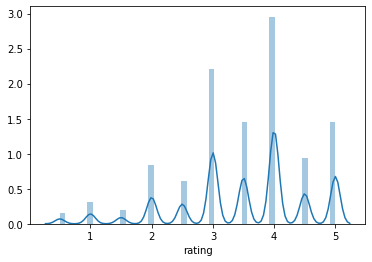

In [3]:
sns.distplot(ratings_df['rating'])

### 학습 데이터, 하이퍼 파라미터 initialize

In [4]:
# 유저-아이템의 Rating 매트릭스
user_item_matrix = ratings_df.pivot_table("rating", "userId", 'movieId').fillna(0)

# numpy 형태로 변환
R = user_item_matrix.to_numpy()

# 잠재 요인의 수
K = 20
learning_rate = 0.01

# l2 정규화 파라미터
regularization = 0.2

# 학습 데이터의 반복 횟수
iterations = 20

num_users, num_items = user_item_matrix.shape

### 학습 파라미터 initialize

In [5]:
# 평균이 0, 표준편차는 1/K로 랜덤하게 initialize
P = np.random.normal(scale = 1./K, size=(num_users, K))
Q = np.random.normal(scale = 1./K, size=(num_items, K))

# Initialize the biases
# 유저별 bias
b_u = np.zeros(num_users)

# 아이템별 bias
b_i = np.zeros(num_items)

# 전체 bias
b = np.mean(R[np.where(R != 0)])

In [6]:
R.shape

(610, 9724)

### 학습 데이터 구성
- 실제 평가를 내린 데이터만 학습에 사용함

In [7]:
samples = [(i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0]

- 총 학습 데이터 사이즈

In [8]:
len(samples)

100836

### SGD를 활용한 파라미터 업데이트

- Parameter Update
![ab](https://i.ibb.co/QCgV5Ys/svd-sgd.png)

In [9]:
training_result = []

for epoch in range(iterations):
    
    # 학습 데이터 순서를 셔플링
    np.random.shuffle(samples)
    
    for i, j, r in samples:
        
        # 현재 주어진 파라미터로 predicted rating을 구함
        prediction = b + b_u[i] + b_i[j] + P[i, :].dot(Q[j, :].T)
        
        # 실제 rating과 predicted rating의 차이가 error
        e = (r - prediction)
        
        # 유저, 아이템 bias 파라미터를 업데이트
        b_u[i] += learning_rate * (e - regularization * b_u[i])
        b_i[j] += learning_rate * (e - regularization * b_i[j])
        
        # 유저, 아이템 잠재 행렬 파라미터를 업데이트
        P[i, :] += learning_rate * (e * Q[j, :] - regularization * P[i, :])
        Q[j, :] += learning_rate * (e * P[i, :] - regularization * Q[j, :])
        
    # 학습이 모두 끝나고 학습 데이터를 활용해 training loss를 구합니다.
    ut, it = R.nonzero()
    predicted_R = b + b_u[:, np.newaxis] + b_i[np.newaxis, :] + P.dot(Q.T) # add new axis, dimension 1 => 2
    error = []
    
    for x, y in zip(ut, it):
        error.append(pow(R[x, y] - predicted_R[x, y], 2))
    rmse = np.sqrt(np.asarray(error).mean())
    print(epoch + 1, rmse)
    training_result.append([epoch + 1, rmse])
    
traing_result_pd = pd.DataFrame(training_result, columns = ['iteration', 'rmse'])

1 0.8985076095560088
2 0.8767818798319986
3 0.8646634286524926
4 0.8574577657899166
5 0.8512418143350183
6 0.8464153437723833
7 0.8437287263911325
8 0.8401694267334513
9 0.8378809686168452
10 0.8348362479769528
11 0.8328189670186613
12 0.831432361999392
13 0.8287099317241761
14 0.8282899406788337
15 0.8263952894590282
16 0.8244698706894156
17 0.8236359103608241
18 0.8232049663362809
19 0.8212657765542805
20 0.8207961066513243


## 02. MF with Class

In [10]:
import numpy as np

# 위에서 구한 MF를 SGD로 학습하는 것을 class 형태로 만듦

class MF():

    def __init__(self, R, K, learning_rate, regularization, iterations):
        """
        Arguments
        - R (ndarray)             : 유저 아이템 매트릭스
        - K (int)                 : latent factor 차원
        - learning_rate (float)   : learning rate
        - regularization (float)  : regularization parameter
        """
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.iterations = iterations

    def train(self):
        
        # 유저, 아이템 잠재 요인 행렬 초기화
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # 유저, 아이템, 글로벌 bias 초기화
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # 학습 데이터 생성
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # iteration 개수만큼 전체 데이터에 대해서 SGD 수행
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            training_process.append((i, rmse))
            if (i+1) % 10 == 0:
                print("Iteration: %d, error = %.4f" % (i+1, rmse))

        return pd.DataFrame(training_process, columns = ['iteration', 'rmse'])

    def rmse(self):
        """
        전체 학습 데이터에 대한 rmse 계산
        """
        ut, it = self.R.nonzero()
        predicted_R = self.full_matrix()
        error = []
        for x, y in zip(ut, it):
            error.append(pow(R[x, y] - predicted_R[x, y], 2))
        return np.sqrt(np.asarray(error).mean())

    def sgd(self):
        """
        sgd로 파라미터 업데이트가 되는 함수
        """
        for i, j, r in self.samples:
            # 실제 rating과 predicted rating을 구하고 error를 구함
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # bias 업데이트
            self.b_u[i] += self.learning_rate * (e - self.regularization * self.b_u[i])
            self.b_i[j] += self.learning_rate * (e - self.regularization * self.b_i[j])

            # 유저, 아이템 잠재 요인 행렬 업데이트
            self.P[i, :] += self.learning_rate * (e * self.Q[j, :] - self.regularization * self.P[i,:])
            self.Q[j, :] += self.learning_rate * (e * self.P[i, :] - self.regularization * self.Q[j,:])

    def get_rating(self, i, j):
        """
        유저 i, 아이템 j에 대한 예측 평점
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        예측된 유저 아이템 매트릭스를 계산 Rhat
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

#### 주어진 유저-아이템 매트릭스

In [11]:
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

mf = MF(R, K=2, learning_rate=0.1, regularization=0.01, iterations=30)

#### MF 모델 학습

In [12]:
train_result_df = mf.train()

Iteration: 10, error = 0.0691
Iteration: 20, error = 0.0128
Iteration: 30, error = 0.0104


#### 예측 매트릭스

In [13]:
mf.full_matrix()

array([[4.98216574, 3.00148616, 3.12893148, 1.01203491],
       [3.99472109, 2.39797629, 2.72437338, 1.01210592],
       [1.00763819, 1.00567955, 4.98663646, 4.98650283],
       [1.00864123, 1.15959422, 3.84891291, 3.99471856],
       [1.96237706, 1.0159439 , 4.98871176, 3.99853666]])

## 03. 무비렌즈 데이터로 학습

In [14]:
user_item_matrix = ratings_df.pivot_table('rating', 'userId', 'movieId').fillna(0)
R = user_item_matrix.to_numpy()
K = 20
learning_rate = 0.01
regularization = 0.2

mf = MF(R, K, learning_rate, regularization, iterations=30)

In [15]:
train_result_df = mf.train()

Iteration: 10, error = 0.8351
Iteration: 20, error = 0.8202
Iteration: 30, error = 0.8131


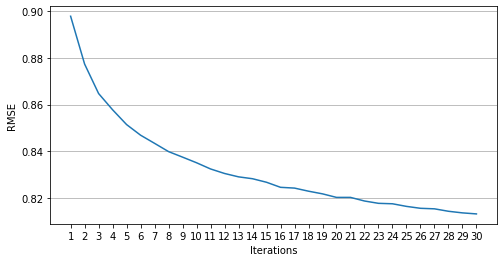

In [16]:
# iteration에 따른 training loss

x = train_result_df.iteration.values + 1
y = train_result_df.rmse.values
plt.figure(figsize=((8,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.grid(axis="y")

## 04. Matrix Factorization의 ALS 구현
1. 초기 사용자, 아이템 행렬을 초기화
2. 아이템 행렬을 고정하고 사용자 행렬을 최적화
3. 사용자 행렬을 고정하고 아이템 행렬을 최적화
4. 2, 3의 과정을 반복

### 유저-아이템 행렬

In [17]:
R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0], ])

### 학습 데이터, 하이퍼 파라미터 초기화

In [18]:
# 잠재요인 개수
k = 5

# l2 하이퍼파라미터
regularization = 0.01

num_users, num_items = R.shape

# ALS 업데이트 횟수 - SGD보다 많다
iterations = 100

### 유저, 아이템 잠재요인 매트릭스

In [19]:
users = np.random.normal(scale=1./k, size=(num_users, k))
items = np.random.normal(scale=1./k, size=(num_items, k))

In [20]:
items.shape

(5, 5)

### ALS 업데이트 수식
![수식](https://i.ibb.co/Csh6Yb0/2021-06-25-10-50-03.png)

#### iteration마다 위에 있는 수식을 활용해 유저, 아이템을 업데이트 한다.
[참고](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html)

In [21]:
training_process = []

for epoch in range(iterations):
    for i, Ri in enumerate(R):
        users[i] = np.linalg.solve(np.dot(items.T, items) + regularization * np.eye(k), \
                                  np.dot(items.T, R[i].T)).T
        
    for j, Rj in enumerate(R.T):
        items[j] = np.linalg.solve(np.dot(users.T, users) + regularization * np.eye(k), \
                                  np.dot(users.T, R[:, j]))
        
    cost = 0
    xi, yi = R.nonzero()
    
    for x, y in zip(xi, yi):
        cost += pow(R[x, y] - users[x, :].dot(items[y, :].T), 2)
        
    cost = np.sqrt(cost / len(xi))
    training_process.append((epoch, cost))
    
    if (epoch + 1) % 10 == 0:
        print("Iteration: %d, cost = %.4f" % (epoch+1, cost))

Iteration: 10, cost = 0.0012
Iteration: 20, cost = 0.0014
Iteration: 30, cost = 0.0015
Iteration: 40, cost = 0.0017
Iteration: 50, cost = 0.0019
Iteration: 60, cost = 0.0020
Iteration: 70, cost = 0.0021
Iteration: 80, cost = 0.0023
Iteration: 90, cost = 0.0024
Iteration: 100, cost = 0.0025


In [22]:
R

array([[1, 0, 0, 1, 3],
       [2, 0, 3, 1, 1],
       [1, 2, 0, 5, 0],
       [1, 0, 0, 4, 4],
       [2, 1, 5, 4, 0],
       [5, 1, 5, 4, 0],
       [0, 0, 0, 1, 0]])

In [23]:
R_hat = users.dot(items.T)
R_hat

array([[ 9.98975638e-01, -4.69085255e-03, -9.39086723e-07,
         1.00240683e+00,  2.99618917e+00],
       [ 1.99991549e+00, -9.89489528e-04,  2.99831551e+00,
         1.00142440e+00,  9.98392956e-01],
       [ 9.99889331e-01,  1.99527754e+00,  1.76498836e-03,
         4.99844281e+00,  9.11066701e-04],
       [ 1.00061424e+00,  4.51013653e-03,  6.62001072e-04,
         3.99749804e+00,  3.99837385e+00],
       [ 2.00470453e+00,  9.99196095e-01,  4.99602129e+00,
         3.99901825e+00, -4.19181670e-04],
       [ 4.99483720e+00,  1.00156207e+00,  5.00127110e+00,
         4.00001202e+00,  1.57554721e-03],
       [ 3.31383008e-04,  4.13530988e-03,  4.67461959e-04,
         9.97899755e-01,  1.37872304e-03]])

## 05. ALS 클래스 구현

In [24]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

class AlternatingLeastSquares():
    def __init__(self, R, k, regularization, iterations, verbose=False):
        """
        Arguments
        - R (ndarray)             : 유저 아이템 매트릭스
        - k (int)                 : latent factor 차원
        - reg_param (float)       : regularization parameter
        - epochs (int)            : als로 파라미터 업데이트를 수행하는 횟수
        - verbose (boolean)       : 학습 과정의 status print 옵션
        """
        self.R = R
        self.num_users, self.num_items = R.shape
        self.k = k
        self.regularization = regularization
        self.iterations = iterations
        self.verbose = verbose


    def fit(self):

        # 유저, 아이템 매트릭스를 초기화
        self.users = np.random.normal(scale=1./k, size=(self.num_users, self.k))
        self.items = np.random.normal(scale=1./k, size=(self.num_items, self.k))

        # iteration 개수만큼 ALS를 수행하여 유저, 아이템 파라미터를 업데이트함
        self._training_process = [] 
        for iteration in range(self.iterations):
            for i, Ri in enumerate(self.R):
                self.users[i] = self.user_latent(i, Ri)

            for j, Rj in enumerate(self.R.T):
                self.items[j] = self.item_latent(j, Rj)
            
            # iteration 수행이 끝날때마다 training loss를 계산함
            cost = self.cost()
            self._training_process.append((iteration, cost))

            # 10번째마다 loss를 출력하는 옵션
            if self.verbose == True and ((iteration + 1) % 10 == 0):
                print("Iteration: %d, cost = %.4f" % (iteration + 1, cost))

    def cost(self):
        """
        학습 데이터 전체의 rmse 계산
        """
        xi, yi = self.R.nonzero()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self.R[x, y] - self.get_prediction(x, y), 2)
        return np.sqrt(cost/len(xi))


    def user_latent(self, i, Ri):
        """
        유저 i에 대한 유저 벡터 업데이트
        """

        du = np.linalg.solve(np.dot(self.items.T, self.items) + self.regularization * np.eye(self.k),
                                   np.dot(self.items.T, self.R[i].T)).T
        return du

    def item_latent(self, j, Rj):
        """
        아이템 j에 대한 아이템 벡터 업데이트
        """

        di = np.linalg.solve(np.dot(self.users.T, self.users) + self.regularization * np.eye(self.k),
                                 np.dot(self.users.T, self.R[:, j]))
        return di


    def get_prediction(self, i, j):
        """
        유저 i, 아이템 j에 대한 예측 평점
        """
        return self.users[i, :].dot(self.items[j, :].T)


    def get_full_matrix(self):
        """
        예측된 유저 아이템 매트릭스를 계산 Rhat
        """
        return self.users.dot(self.items.T)

In [25]:
R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])

als = AlternatingLeastSquares(R = R, regularization = 0.01, iterations=20, verbose=True, k=5)
als.fit()

Iteration: 10, cost = 0.0009
Iteration: 20, cost = 0.0012


In [26]:
als.get_full_matrix()

array([[ 1.00054010e+00, -3.47877765e-03, -3.07850656e-05,
         1.00145857e+00,  2.99780665e+00],
       [ 2.00031893e+00, -9.63067626e-04,  2.99943684e+00,
         1.00064909e+00,  9.99116778e-01],
       [ 1.00022716e+00,  1.99745563e+00,  6.02141466e-04,
         5.00002898e+00, -3.05200754e-04],
       [ 9.99870035e-01,  2.83436033e-03,  1.87015227e-04,
         3.99878779e+00,  4.00031825e+00],
       [ 2.00187426e+00,  9.99325083e-01,  4.99864343e+00,
         3.99992359e+00, -8.74636355e-04],
       [ 4.99783945e+00,  1.00132656e+00,  5.00052129e+00,
         3.99968444e+00,  1.42307860e-03],
       [-4.86904306e-04,  2.88566877e-03,  1.63767264e-04,
         9.98806174e-01,  1.31175866e-03]])

In [27]:
als.get_prediction(1, 3)

1.0006490940803254

## 06. Surprise에서 제공하는 MF 모델(SVD)
- Surprise 패키지의 SVD는 SGD로 학습되는 MF를 의미한다.
- SGD로 모델이 학습될 대 변경 가능한 옵션과 하이퍼파라미터에 대해 살펴본다.
- 무비렌즈 데이터를 활용해 kNN 모델과 SVD 모델을 각각 학습해보고 추천 성능을 비교해본다.

In [28]:
# surprise에서 제공하는 dataset과 reader

from surprise import Reader, Dataset

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [29]:
from surprise import accuracy
from surprise.model_selection import train_test_split

# train / test 데이터 나누기
train_data, test_data = train_test_split(data, test_size=0.2, random_state=10)

### SVD Model

- [모델 API 문서](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)
- The SVD++ algorithm, an extension of SVD taking into account implicit ratings.

In [30]:
# SVD 모델을 사용하자 => MF의 SGD 구현을 Suprise에서 SVD로 부름

svd_model = SVD(n_factors=20, reg_all = 0.02)

# 학습데이터를 가지고 모델 학습
svd_model.fit(train_data)

# 테스트 데이터로 모델의 예측 평점을 추론
predictions = svd_model.test(test_data)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8660


0.8660030808698003

#### 유저/아이템 매트릭스

In [31]:
print(svd_model.pu.shape)
print(svd_model.qi.shape)

(610, 20)
(8933, 20)


#### 유저 0의 latent factor

In [32]:
svd_model.pu[0]

array([-0.03099873, -0.05642505, -0.07785974, -0.16784845, -0.10577581,
        0.05834872,  0.07545349, -0.02610836, -0.00734263,  0.12959561,
       -0.15351897,  0.06536194,  0.08620424,  0.1744412 , -0.05833897,
       -0.20289811,  0.20321874, -0.3789021 , -0.15915271, -0.01673731])

#### 아이템 0의 latent factor

In [33]:
svd_model.qi[0]

array([ 0.25599293, -0.24280786,  0.00535914,  0.09900458, -0.13744529,
       -0.23939816,  0.02116269, -0.04442159,  0.27611131,  0.18141644,
       -0.08812498, -0.1745348 ,  0.03973557,  0.28163829, -0.21130212,
       -0.06865931, -0.2036131 ,  0.27009727, -0.0720132 ,  0.03788732])

#### 평점 예측

In [34]:
user_id = 1
item_id = 1

svd_model.predict(user_id, item_id)

Prediction(uid=1, iid=1, r_ui=None, est=4.611782498381671, details={'was_impossible': False})

#### 새로운 유저, 아이템이 등장할 경우 default_prediction을 사용
![default_prediction](https://i.ibb.co/6YxrX1s/default-prediction.png)

In [35]:
user_id = 0
item_id = 0

print(svd_model.predict(user_id, item_id).est)
print(svd_model.default_prediction())

3.5001859473397134
3.5001859473397134


### [모델 상세 옵션](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

- Rating Function
![ab](https://i.ibb.co/MSZJKLp/svd-rating.png)
- Objective Function
![ab](https://i.ibb.co/DzMmtyx/svd-obj.png)

#### bias 유무에 따른 성능 비교

In [36]:
for biased in [False, True]:
    svd_model = SVD(biased=biased)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('biased:', biased, ',', accuracy.rmse(predictions))

RMSE: 0.9852
biased: False , 0.985227512074916
RMSE: 0.8704
biased: True , 0.8703636789383212


#### latent factor 수에 따른 성능 비교

In [37]:
for k in [25, 50, 100, 150]:
    svd_model = SVD(n_factors=k)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('n_factors:', k, ',', accuracy.rmse(predictions))

RMSE: 0.8669
n_factors: 25 , 0.866884038010784
RMSE: 0.8680
n_factors: 50 , 0.8680162935758132
RMSE: 0.8726
n_factors: 100 , 0.8725720245049245
RMSE: 0.8747
n_factors: 150 , 0.8747062420938684


#### learning rate에 따른 성능 비교

In [38]:
for lr_all in [.0025, .005, .001]:
    svd_model = SVD(lr_all=lr_all)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('lr_all:', lr_all, ',', accuracy.rmse(predictions))

RMSE: 0.8776
lr_all: 0.0025 , 0.8776344461608272
RMSE: 0.8699
lr_all: 0.005 , 0.8699222480341662
RMSE: 0.8951
lr_all: 0.001 , 0.8950513514160988


#### regularization에 따른 성능 비교

In [39]:
for reg_all in [0, 0.02, 0.1, 1]:
    svd_model = SVD(reg_all=reg_all)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('reg_all:', reg_all, ',', accuracy.rmse(predictions))

RMSE: 0.8937
reg_all: 0 , 0.8936555235686122
RMSE: 0.8704
reg_all: 0.02 , 0.870430014866698
RMSE: 0.8673
reg_all: 0.1 , 0.8673302158459903
RMSE: 0.9051
reg_all: 1 , 0.905099471006505


#### Grid Search 패키지를 제공함

In [40]:
from surprise.model_selection import GridSearchCV

grid = {'lr_all': [.0025, .005], 
        'n_factors': [25, 50, 100],
        'reg_all': [0.02, 0.1]
       }

gs = GridSearchCV(SVD, grid, measures=['RMSE'], cv=2)
gs.fit(data)

In [41]:
pd.DataFrame(gs.cv_results).sort_values(by='rank_test_rmse')

,split0_test_rmse,split1_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_lr_all,param_n_factors,param_reg_all
7,0.879590,0.881011,0.880301,0.000711,1,2.306833,0.004266,0.677244,0.006639,"{'lr_all': 0.005, 'n_factors': 25, 'reg_all': ...",0.0050,25,0.10
9,0.880503,0.881280,0.880891,0.000388,2,3.600934,0.186163,0.794973,0.108060,"{'lr_all': 0.005, 'n_factors': 50, 'reg_all': ...",0.0050,50,0.10
11,0.881055,0.881315,0.881185,0.000130,3,5.557814,0.045481,0.668756,0.000647,"{'lr_all': 0.005, 'n_factors': 100, 'reg_all':...",0.0050,100,0.10
6,0.880162,0.882769,0.881466,0.001303,4,2.374165,0.014508,0.647510,0.003196,"{'lr_all': 0.005, 'n_factors': 25, 'reg_all': ...",0.0050,25,0.02
8,0.883886,0.884087,0.883987,0.000101,5,3.371479,0.032349,0.616422,0.041925,"{'lr_all': 0.005, 'n_factors': 50, 'reg_all': ...",0.0050,50,0.02
0,0.888658,0.888974,0.888816,0.000158,6,2.346534,0.043830,0.689923,0.001761,"{'lr_all': 0.0025, 'n_factors': 25, 'reg_all':...",0.0025,25,0.02
10,0.888655,0.889426,0.889040,0.000385,7,6.030160,0.482804,0.688143,0.007303,"{'lr_all': 0.005, 'n_factors': 100, 'reg_all':...",0.0050,100,0.02
1,0.889274,0.889322,0.889298,0.000024,8,2.389229,0.070999,0.741644,0.064878,"{'lr_all': 0.0025, 'n_factors': 25, 'reg_all':...",0.0025,25,0.10
3,0.889744,0.889641,0.889693,0.000052,9,3.436527,0.006205,0.665408,0.009951,"{'lr_all': 0.0025, 'n_factors': 50, 'reg_all':...",0.0025,50,0.10
5,0.890260,0.890628,0.890444,0.000184,10,5.602694,0.062305,0.668211,0.001114,"{'lr_all': 0.0025, 'n_factors': 100, 'reg_all'...",0.0025,100,0.10


In [42]:
print(gs.best_score)
print(gs.best_params)

{'rmse': 0.8803006451797001}
{'rmse': {'lr_all': 0.005, 'n_factors': 25, 'reg_all': 0.1}}


## 07. 예측 모델 간의 성능 비교
- kNN과 MF(SVD) 사이의 모델 성능 비교

### kNN 모델

In [43]:
sim_options = {
    'name': 'msd',
    'user_based': False
}

knn = KNNWithMeans(k = 40, min_k = 1, sim_options = sim_options)

cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8940  0.8874  0.8959  0.8922  0.8922  0.8923  0.0028  
MAE (testset)     0.6815  0.6785  0.6855  0.6836  0.6820  0.6822  0.0024  
Fit time          7.60    7.49    7.51    7.41    7.39    7.48    0.08    
Test time         13.08   12.32   12.36   12.36   12.31   12.49   0.30    


{'test_rmse': array([0.89395714, 0.88743407, 0.8958937 , 0.89222901, 0.89222254]),
 'test_mae': array([0.68147979, 0.67845507, 0.68553271, 0.68362014, 0.68197489]),
 'fit_time': (7.600543975830078,
  7.492369651794434,
  7.514346361160278,
  7.412439584732056,
  7.39105749130249),
 'test_time': (13.083563566207886,
  12.317754030227661,
  12.362648010253906,
  12.3638174533844,
  12.313887119293213)}

### SVD 모델

In [44]:
svd = SVD(n_factors=25, lr_all=0.005, reg_all=0.1)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8646  0.8719  0.8701  0.8779  0.8692  0.8707  0.0043  
MAE (testset)     0.6659  0.6714  0.6694  0.6749  0.6695  0.6703  0.0029  
Fit time          3.58    3.60    3.58    3.58    3.58    3.59    0.01    
Test time         0.30    0.21    0.21    0.21    0.22    0.23    0.03    


{'test_rmse': array([0.86458575, 0.8719132 , 0.87005604, 0.87786239, 0.86923162]),
 'test_mae': array([0.66593297, 0.67144204, 0.66944609, 0.67493962, 0.66951888]),
 'fit_time': (3.575917959213257,
  3.603013038635254,
  3.5769147872924805,
  3.5842466354370117,
  3.584979772567749),
 'test_time': (0.3022267818450928,
  0.2131941318511963,
  0.21445083618164062,
  0.21469783782958984,
  0.21930265426635742)}